In [1]:
from hossam import *
from pandas import DataFrame, concat
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import log_loss, confusion_matrix, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, precision_recall_curve

from scipy.spatial import ConvexHull

from 성능평가함수 import *

import shap

In [2]:
origin=load_data('pima_indians_diabetes_preprocessed')
print('\n===== 데이터 크기 확인 =====')
print(f'데이터셋 크기 : {origin.shape}')
print(f'행 개수 : {origin.shape[0]}개')
print(f'열 개수 : {origin.shape[1]}개')
print('\n===== 타입 확인 =====')
print(origin.info())
origin.head()

캐글에서 제공하는 pima_indians_diabetes의 전처리 완료 버전(결측치 정제+로그변환) (출처: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)

===== 데이터 크기 확인 =====
데이터셋 크기 : (768, 9)
행 개수 : 768개
열 개수 : 9개

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float64
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    float64
 8   Outcome                   768 non-null    int64  
dtypes: float64(7), int64(2)
memory usage: 54.1 KB
None


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1.946,5.004,72,3.584,4.836,3.544,0.487,3.932,1
1,0.693,4.454,66,3.401,4.836,3.318,0.301,3.466,0
2,2.197,5.215,64,3.401,4.836,3.190,0.514,3.497,1
3,0.693,4.500,66,3.178,4.554,3.371,0.154,3.091,0
4,0.000,4.927,40,3.584,5.130,3.786,1.190,3.526,1


In [3]:
df=origin.copy()

df['Outcome']=df['Outcome'].astype('int')

yname='Outcome'
x=df.drop(columns=[yname])
y=df[yname]

x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2, random_state=52)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

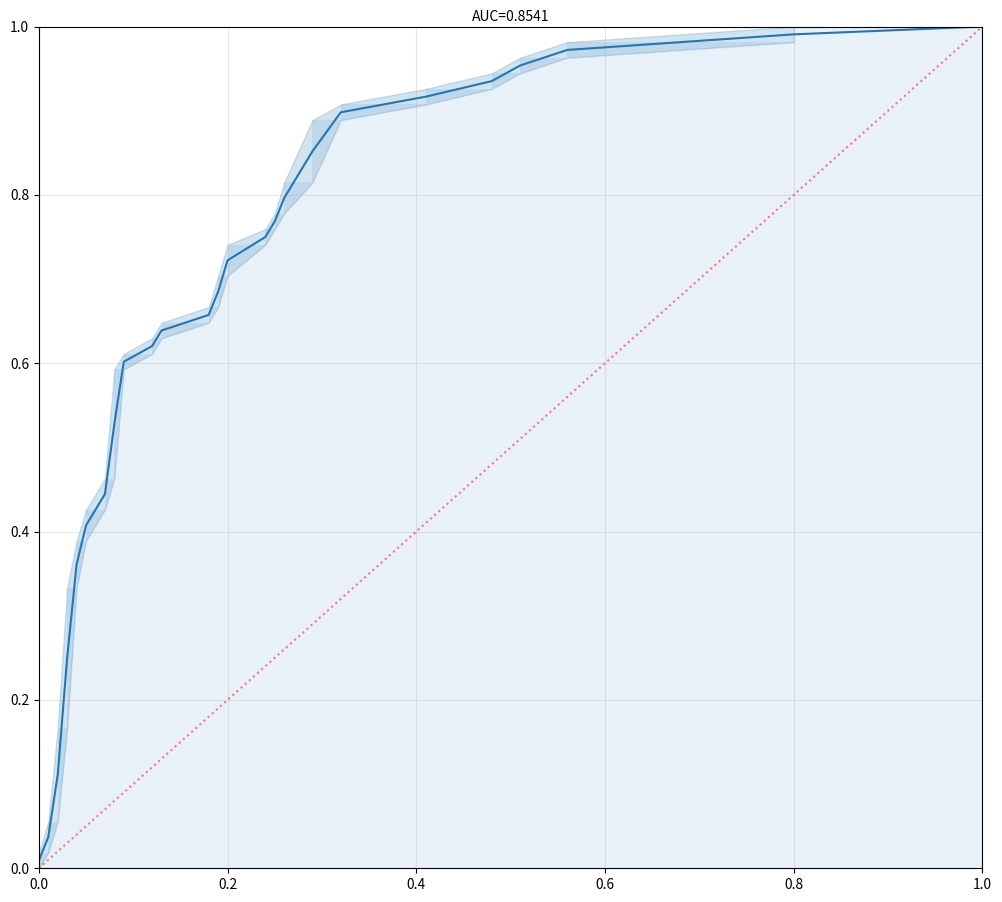

CPU times: total: 562 ms
Wall time: 6.54 s


,정확도(Accuracy),정밀도(Precision),"재현율(Recall, tpr)","위양성율(Fallout, fpr)",특이성(TNR),F1 Score,AUC
LogisticRegression,0.766,0.629,0.815,0.260,0.740,0.710,0.854


In [4]:
%%time

logit_pipe=Pipeline([
    ('VIF_Selector', VIFSelector()),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=52))
])

logit_param_grid={
    'model__penalty':['l2'],
    'model__solver':['lbfgs'],
    'model__C':[0.01, 0.1, 1, 10, 100],
    'model__max_iter':[100, 300, 500],
    'model__class_weight':[None, 'balanced']
}

logit_gs=GridSearchCV(estimator=logit_pipe, param_grid=logit_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

logit_gs.fit(x_train, y_train)

logit_estimator=logit_gs.best_estimator_

logit_score_df=hs_cls_bin_scores(logit_estimator, x_test, y_test)
logit_score_df

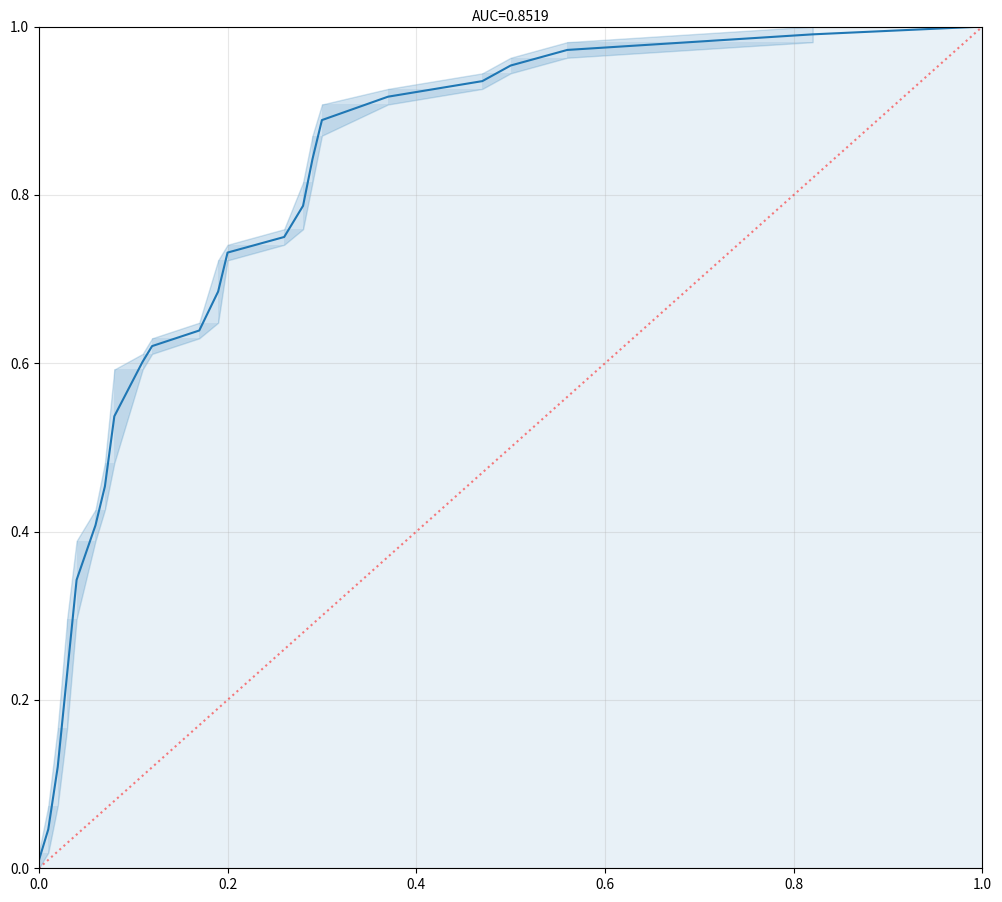

CPU times: total: 1 s
Wall time: 2.18 s


,정확도(Accuracy),정밀도(Precision),"재현율(Recall, tpr)","위양성율(Fallout, fpr)",특이성(TNR),F1 Score,AUC
SGDClassifier,0.773,0.694,0.630,0.150,0.850,0.660,0.852


In [5]:
%%time

sgd_pipe=Pipeline([
    ('VIF_Selector', VIFSelector()),
    ('scaler', StandardScaler()),
    ('model', SGDClassifier(random_state=52, n_jobs=-1))
])

sgd_param_grid={
    'model__loss':['hinge', 'log_loss', 'modified_huber'],
    'model__penalty':['l2', 'l1', 'elasticnet'],
    'model__alpha':[0.01, 0.1, 1, 10, 100],
    'model__max_iter':[1000, 2000, 5000],
    'model__class_weight':[None, 'balanced']
}

sgd_gs=GridSearchCV(estimator=sgd_pipe, param_grid=sgd_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

sgd_gs.fit(x_train, y_train)

sgd_estimator=sgd_gs.best_estimator_

sgd_score_df=hs_cls_bin_scores(sgd_estimator, x_test, y_test)
sgd_score_df

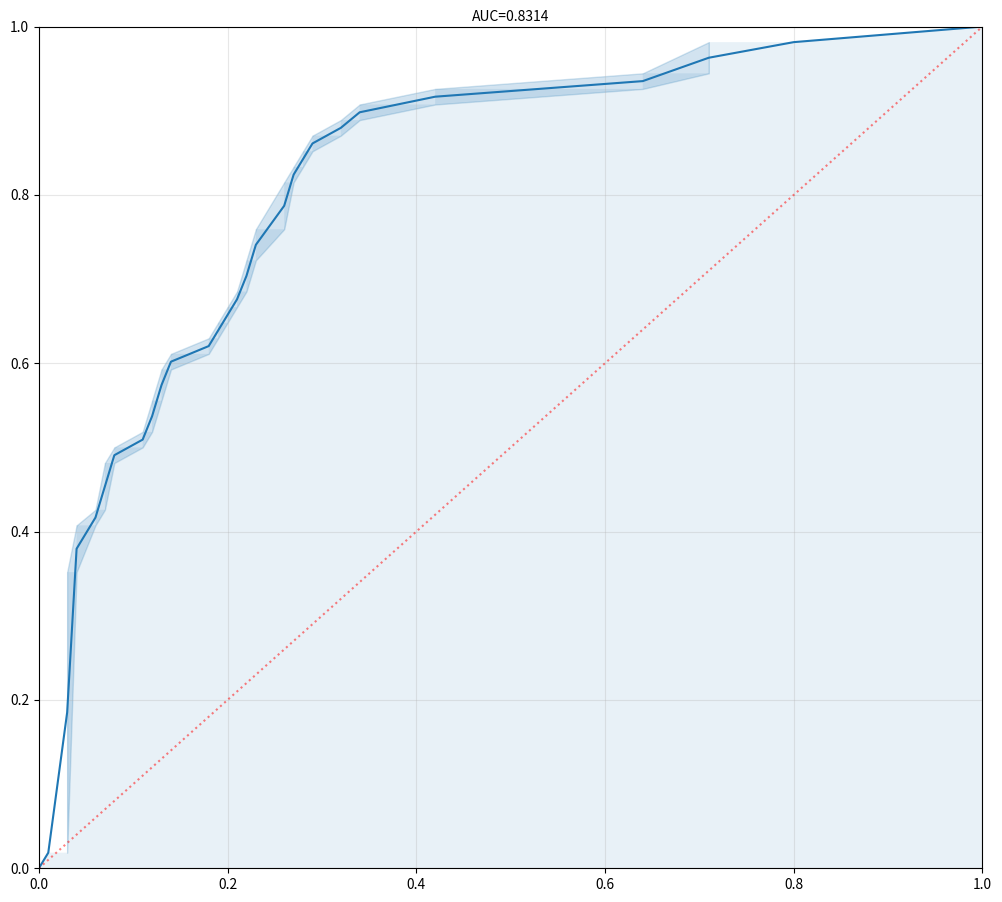

CPU times: total: 672 ms
Wall time: 7.11 s


,정확도(Accuracy),정밀도(Precision),"재현율(Recall, tpr)","위양성율(Fallout, fpr)",특이성(TNR),F1 Score,AUC
KNeighborsClassifier,0.747,0.642,0.630,0.190,0.810,0.636,0.831


In [7]:
%%time

knn_cls_pipe=Pipeline([
    ('VIF_Selector', VIFSelector()),
    ('scaler', StandardScaler()),
    ('model', KNeighborsClassifier(n_jobs=-1))
])

knn_cls_param_grid={
    'model__n_neighbors':[3, 5, 7, 9, 15, 25],
    'model__weights':['uniform', 'distance'],
    'model__metric':['euclidean', 'manhattan', 'minkowski'],
    'model__p':[1, 2],
    'model__weights':['uniform', 'distance']
}

knn_cls_gs=GridSearchCV(estimator=knn_cls_pipe, param_grid=knn_cls_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

knn_cls_gs.fit(x_train, y_train)

knn_cls_estimator=knn_cls_gs.best_estimator_

knn_cls_score_df=hs_cls_bin_scores(knn_cls_estimator, x_test, y_test)
knn_cls_score_df

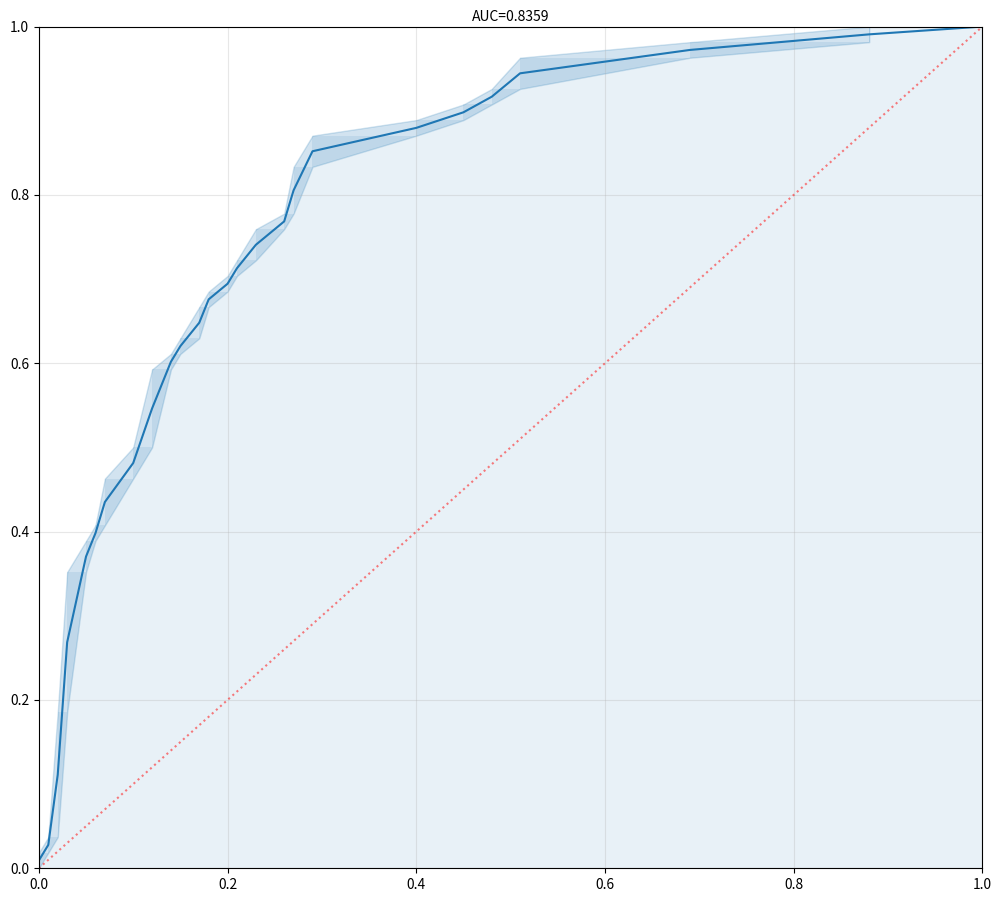

CPU times: total: 812 ms
Wall time: 9.71 s


,정확도(Accuracy),정밀도(Precision),"재현율(Recall, tpr)","위양성율(Fallout, fpr)",특이성(TNR),F1 Score,AUC
SVC,0.753,0.608,0.833,0.290,0.710,0.703,0.836


In [9]:
%%time

svc_pipe=Pipeline([
    ('VIF_Selector', VIFSelector()),
    ('scaler', StandardScaler()),
    ('model', SVC(random_state=52, cache_size=200, probability=True))
])

svc_param_grid={
    'model__kernel':['rbf'],
    'model__C':[0.1, 1, 10, 100],
    'model__gamma':['scale', 'auto', 0.01, 0.1, 1],
    'model__degree':[2, 3, 4],
    'model__class_weight':[None, 'balanced']
}

svc_gs=GridSearchCV(estimator=svc_pipe, param_grid=svc_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

svc_gs.fit(x_train, y_train)

svc_estimator=svc_gs.best_estimator_

svc_score_df=hs_cls_bin_scores(svc_estimator, x_test, y_test)
svc_score_df

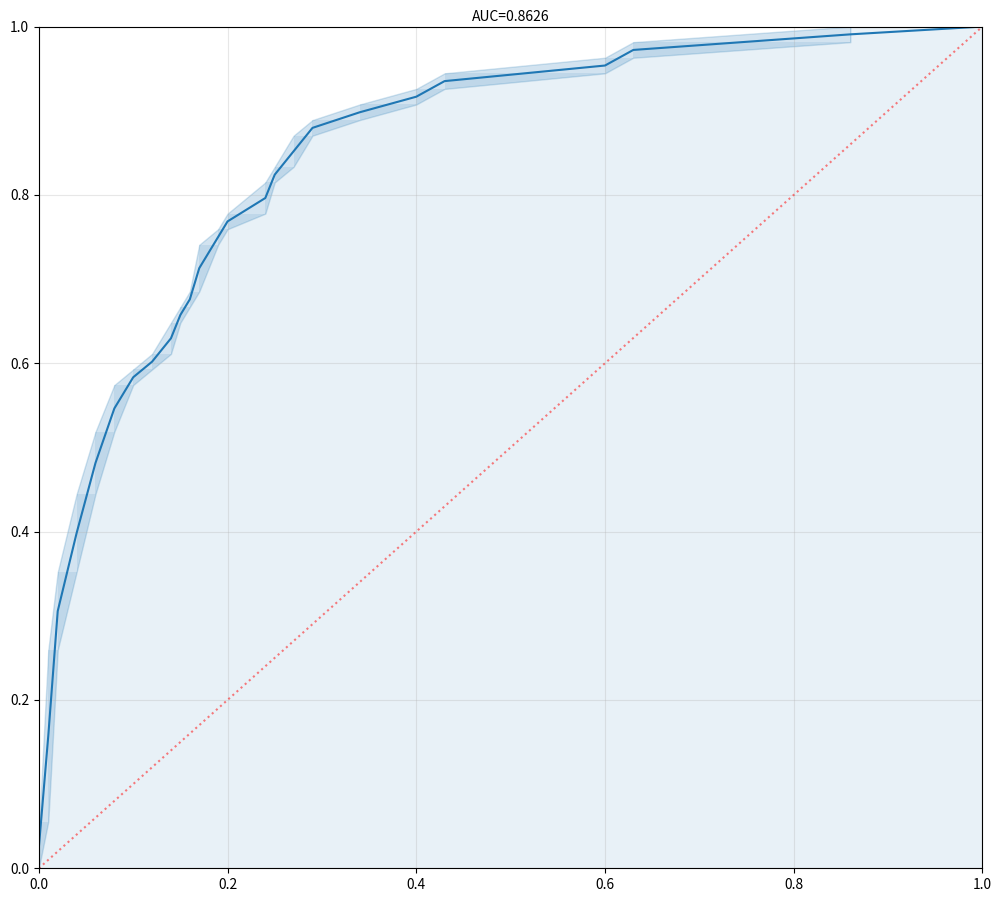

CPU times: total: 1.73 s
Wall time: 24.4 s


,정확도(Accuracy),정밀도(Precision),"재현율(Recall, tpr)","위양성율(Fallout, fpr)",특이성(TNR),F1 Score,AUC
RandomForestClassifier,0.773,0.638,0.815,0.250,0.750,0.715,0.863


In [11]:
%%time

rf_pipe=Pipeline([
    ('VIF_Selector', VIFSelector()),
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=52, n_jobs=-1))
])

rf_param_grid={
    'model__n_estimators':[300, 500],
    'model__max_depth':[None, 10],
    'model__min_samples_leaf':[5, 10],
    'model__max_features':['sqrt', 1.0],
    'model__criterion':['gini', 'entropy'],
    'model__class_weight':[None, 'balanced']
}

rf_gs=GridSearchCV(estimator=rf_pipe, param_grid=rf_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

rf_gs.fit(x_train, y_train)

rf_estimator=rf_gs.best_estimator_

rf_score_df=hs_cls_bin_scores(rf_estimator, x_test, y_test)
rf_score_df

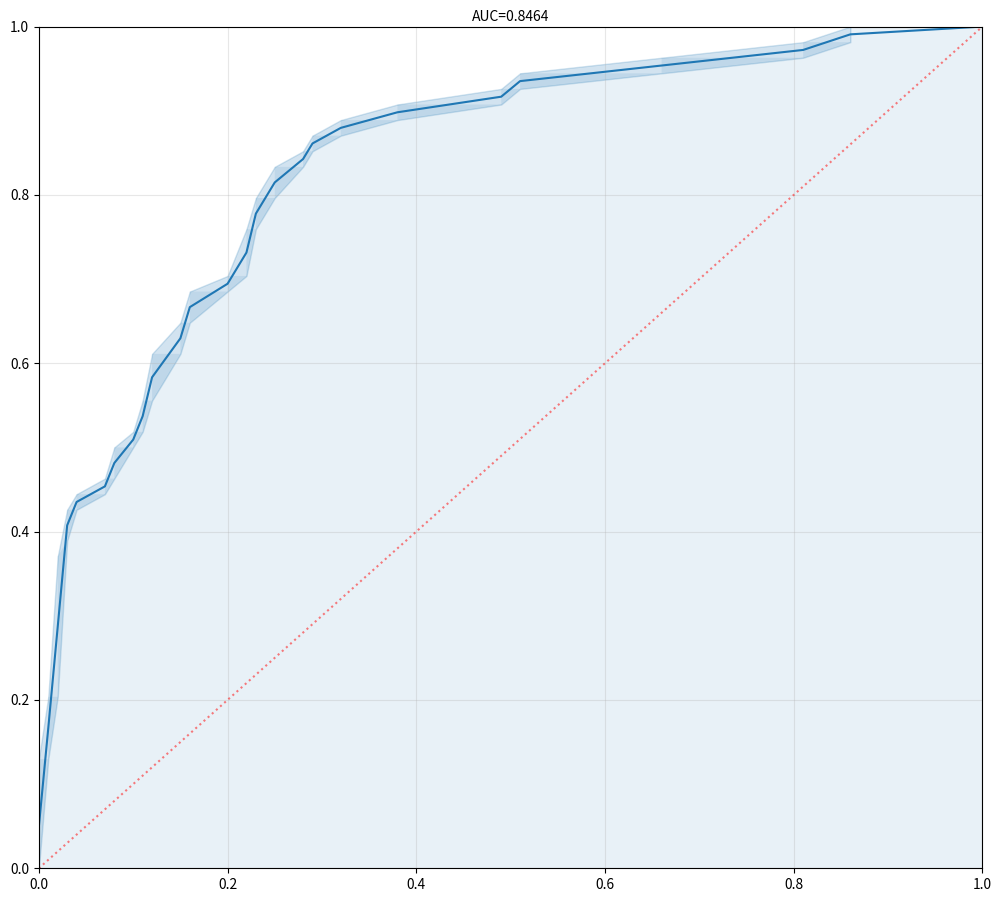

CPU times: total: 19.3 s
Wall time: 2min


,정확도(Accuracy),정밀도(Precision),"재현율(Recall, tpr)","위양성율(Fallout, fpr)",특이성(TNR),F1 Score,AUC
XGBClassifier,0.773,0.686,0.648,0.160,0.840,0.667,0.846


In [12]:
%%time

xgb_cls_pipe=Pipeline([
    ('VIF_Selector', VIFSelector()),
    ('scaler', StandardScaler()),
    ('model', XGBClassifier(objective='binary:logistic', random_state=52, n_jobs=-1))
])

xgb_cls_param_grid={
    'model__n_estimators':[100, 300],
    'model__learning_rate':[0.01, 0.05, 0.1],
    'model__max_depth':[3, 5, 7],
    'model__min_child_weight':[1, 5, 10],
    'model__subsample':[0.6, 0.8, 1.0],
    'model__colsample_bytree':[0.6, 0.8, 1.0],
    'model__reg_alpha':[0, 0.1, 1],
    'model__reg_lambda':[1, 5, 10],
    'model__scale_pos_weight':[1]
}

xgb_cls_gs=GridSearchCV(estimator=xgb_cls_pipe, param_grid=xgb_cls_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

xgb_cls_gs.fit(x_train, y_train)

xgb_cls_estimator=xgb_cls_gs.best_estimator_

xgb_cls_score_df=hs_cls_bin_scores(xgb_cls_estimator, x_test, y_test)
xgb_cls_score_df

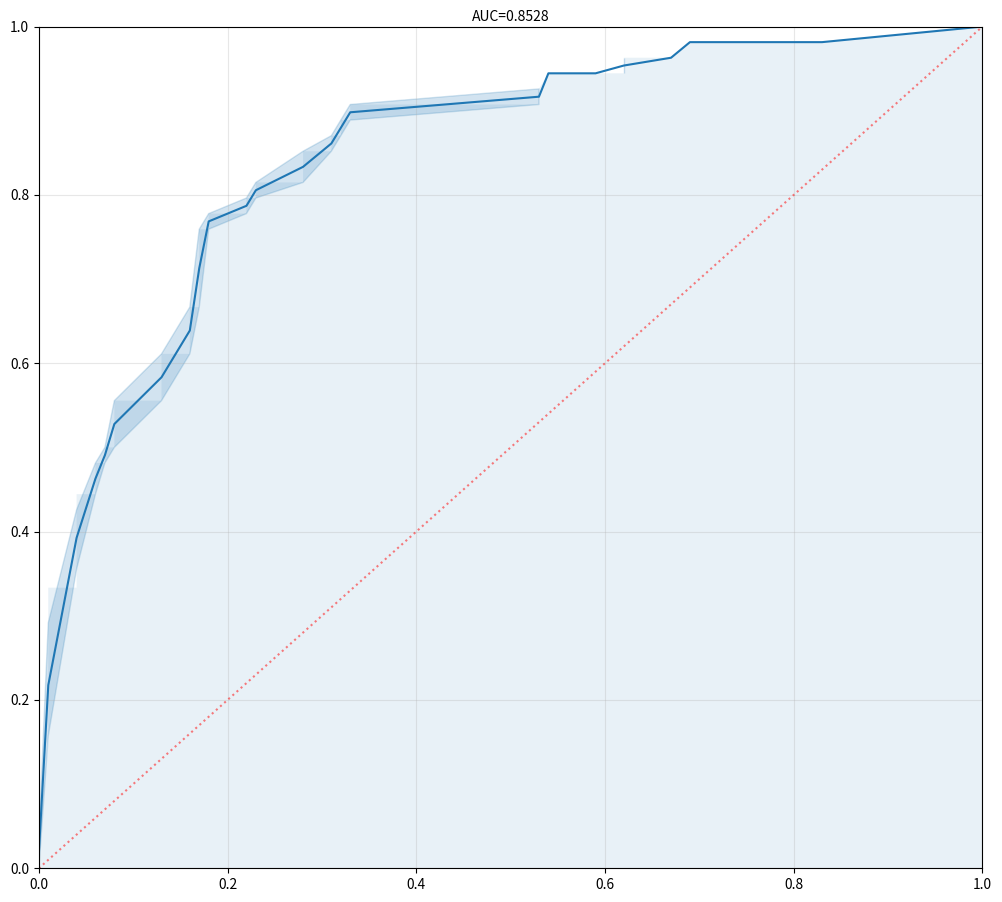

CPU times: total: 2.03 s
Wall time: 14.4 s


,정확도(Accuracy),정밀도(Precision),"재현율(Recall, tpr)","위양성율(Fallout, fpr)",특이성(TNR),F1 Score,AUC
LGBMClassifier,0.766,0.705,0.574,0.130,0.870,0.633,0.853


In [13]:
%%time

lgbm_cls_pipe=Pipeline([
    ('VIF_Selector', VIFSelector()),
    ('scaler', StandardScaler()),
    ('model', LGBMClassifier(objective='binary', random_state=52, n_jobs=-1, verbose=-1))
])

lgbm_cls_param_grid={
    'model__n_estimators':[100, 300],
    'model__learning_rate':[0.01, 0.05, 0.1],
    # 'model__num_leaves':[15, 31],
    # 'model__max_depth':[3, 5],
    # 'model__min_child_weight':[10, 20],
    # 'model__subsample':[0.6, 0.8, 1.0],
    'model__reg_alpha':[0, 0.1, 1],
    'model__reg_lambda':[0, 1, 5],
}

lgbm_cls_gs=GridSearchCV(estimator=lgbm_cls_pipe, param_grid=lgbm_cls_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

lgbm_cls_gs.fit(x_train, y_train)

lgbm_cls_estimator=lgbm_cls_gs.best_estimator_

lgbm_cls_score_df=hs_cls_bin_scores(lgbm_cls_estimator, x_test, y_test)
lgbm_cls_score_df

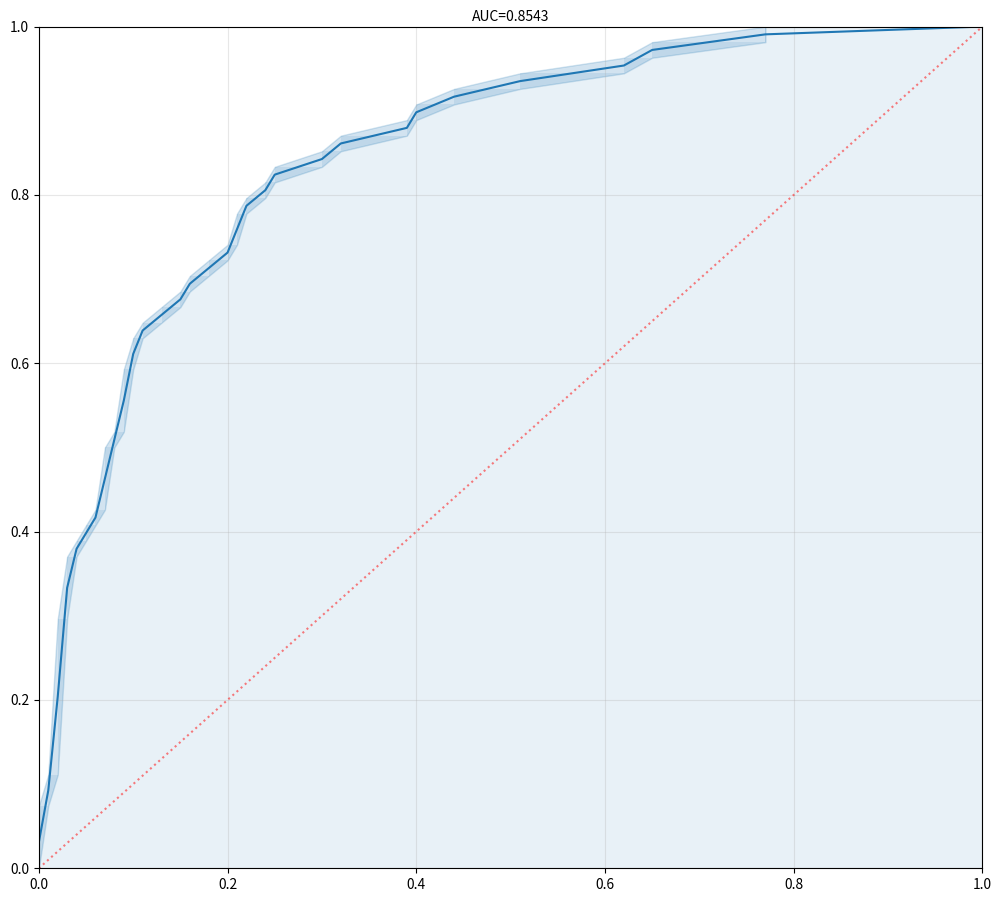

CPU times: total: 3.39 s
Wall time: 1min 14s


,정확도(Accuracy),정밀도(Precision),"재현율(Recall, tpr)","위양성율(Fallout, fpr)",특이성(TNR),F1 Score,AUC
CatBoostClassifier,0.805,0.761,0.648,0.110,0.890,0.700,0.854


In [16]:
%%time

cat_cls_pipe=Pipeline([
    ('model', CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', cat_features=[], random_state=52, thread_count=-1, verbose=0))
])

cat_cls_param_grid=[
    {
        'model__bootstrap_type':['Bayesian'],
        'model__iterations':[300, 500],
        'model__learning_rate':[0.01, 0.03],
        'model__depth':[4, 6],
        'model__l2_leaf_reg':[1, 3],
        'model__rsm':[0.6, 1.0]
    },
    {
        'model__bootstrap_type':['Bernoulli'],
        'model__iterations':[300, 500],
        'model__learning_rate':[0.01, 0.03],
        'model__depth':[4, 6],
        'model__l2_leaf_reg':[1, 3],
        'model__subsample':[0.6, 1.0],
        'model__rsm':[0.6, 1.0]
    }
]

cat_cls_gs=GridSearchCV(estimator=cat_cls_pipe, param_grid=cat_cls_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

cat_cls_gs.fit(x_train, y_train)

cat_cls_estimator=cat_cls_gs.best_estimator_

cat_cls_score_df=hs_cls_bin_scores(cat_cls_estimator, x_test, y_test)
cat_cls_score_df

In [17]:
result_df=concat([logit_score_df, sgd_score_df, knn_cls_score_df, svc_score_df, rf_score_df, xgb_cls_score_df, lgbm_cls_score_df, cat_cls_score_df])
result_df.sort_values('AUC', ascending=False, inplace=True)
result_df

,정확도(Accuracy),정밀도(Precision),"재현율(Recall, tpr)","위양성율(Fallout, fpr)",특이성(TNR),F1 Score,AUC
RandomForestClassifier,0.773,0.638,0.815,0.250,0.750,0.715,0.863
CatBoostClassifier,0.805,0.761,0.648,0.110,0.890,0.700,0.854
LogisticRegression,0.766,0.629,0.815,0.260,0.740,0.710,0.854
LGBMClassifier,0.766,0.705,0.574,0.130,0.870,0.633,0.853
SGDClassifier,0.773,0.694,0.630,0.150,0.850,0.660,0.852
XGBClassifier,0.773,0.686,0.648,0.160,0.840,0.667,0.846
SVC,0.753,0.608,0.833,0.290,0.710,0.703,0.836
KNeighborsClassifier,0.747,0.642,0.630,0.190,0.810,0.636,0.831


In [18]:
result_df.sort_values('재현율(Recall, tpr)', ascending=False)

,정확도(Accuracy),정밀도(Precision),"재현율(Recall, tpr)","위양성율(Fallout, fpr)",특이성(TNR),F1 Score,AUC
SVC,0.753,0.608,0.833,0.290,0.710,0.703,0.836
RandomForestClassifier,0.773,0.638,0.815,0.250,0.750,0.715,0.863
LogisticRegression,0.766,0.629,0.815,0.260,0.740,0.710,0.854
CatBoostClassifier,0.805,0.761,0.648,0.110,0.890,0.700,0.854
XGBClassifier,0.773,0.686,0.648,0.160,0.840,0.667,0.846
SGDClassifier,0.773,0.694,0.630,0.150,0.850,0.660,0.852
KNeighborsClassifier,0.747,0.642,0.630,0.190,0.810,0.636,0.831
LGBMClassifier,0.766,0.705,0.574,0.130,0.870,0.633,0.853
